<a href="https://colab.research.google.com/github/rasecfaria/FinalProject/blob/main/v2_clean.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Movie Recommendation System 🎬

**Objective**: Develop a hybrid recommendation system that combines collaborative filtering with mean-centered normalization and Bayesian averaging to provide personalized and accurate recommendations.

**Key Features**:
- Collaborative filtering based on item similarity
- Mean-centered normalization to correct user bias
- Bayesian averaging to handle movies with few ratings
- Temporal filtering for relevant movies (from 1970 onwards)

## 1. Library Import and Data Loading

In [11]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.sparse import csr_matrix
from sklearn.neighbors import NearestNeighbors
import re

# Configurações para visualização
plt.style.use('default')
sns.set_palette("husl")

In [12]:
# Data loading
ratings = pd.read_csv('data/ratings.csv')
movies = pd.read_csv('data/movies.csv')

# Function to extract year from title
def extract_year(title):
    match = re.search(r'\((\d{4})\)$', title)
    return int(match.group(1)) if match else None

# Basic preprocessing
movies['year'] = movies['title'].apply(extract_year)
movies = movies[movies['year'] >= 1970].reset_index(drop=True)  # Filter old movies
ratings = ratings[ratings['movieId'].isin(movies['movieId'])].reset_index(drop=True)

print(f"Filtered dataset (movies ≥ 1970):")
print(f"Total movies: {len(movies):,}")
print(f"Total ratings: {len(ratings):,}")
print(f"Total users: {ratings['userId'].nunique():,}")

Filtered dataset (movies ≥ 1970):
Total movies: 8,658
Total ratings: 94,239
Total users: 610


## 2. Exploratory Data Analysis

Number of ratings: 94,239
Number of unique movies: 8,649
Number of unique users: 610
Ratings per user (average): 154.5
Ratings per movie (average): 10.9


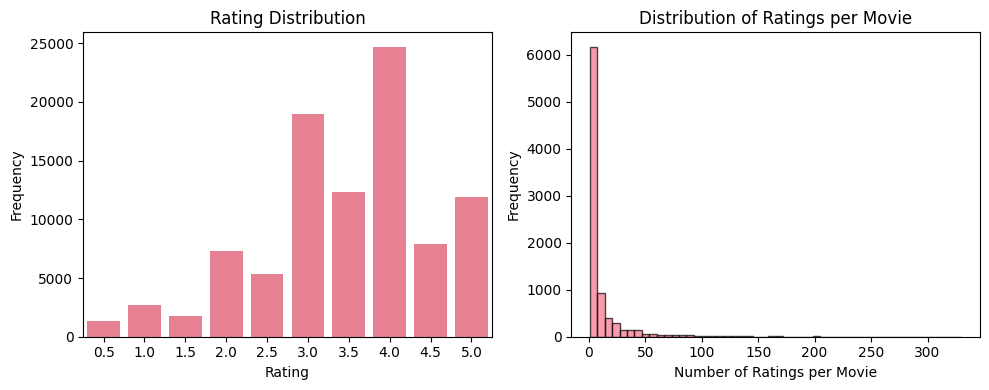


Global average rating: 3.48


In [13]:
# Basic statistics
n_ratings = len(ratings)
n_movies = ratings['movieId'].nunique()
n_users = ratings['userId'].nunique()

print(f"Number of ratings: {n_ratings:,}")
print(f"Number of unique movies: {n_movies:,}")
print(f"Number of unique users: {n_users:,}")
print(f"Ratings per user (average): {n_ratings/n_users:.1f}")
print(f"Ratings per movie (average): {n_ratings/n_movies:.1f}")

# Rating distribution
plt.figure(figsize=(10, 4))
plt.subplot(1, 2, 1)
sns.countplot(data=ratings, x='rating')
plt.title("Rating Distribution")
plt.xlabel('Rating')
plt.ylabel('Frequency')

plt.subplot(1, 2, 2)
movie_counts = ratings['movieId'].value_counts()
plt.hist(movie_counts, bins=50, edgecolor='black', alpha=0.7)
plt.title("Distribution of Ratings per Movie")
plt.xlabel('Number of Ratings per Movie')
plt.ylabel('Frequency')

plt.tight_layout()
plt.show()

print(f"\nGlobal average rating: {ratings['rating'].mean():.2f}")

## 3. Hybrid System Implementation

### 3.1 Mean-Centered Normalization
Normalization corrects the bias of users who tend to give consistently higher or lower ratings.

In [14]:
def normalize_ratings(df):
    """
    Normalizes ratings by subtracting each user's mean.
    """
    user_mean_ratings = df.groupby('userId')['rating'].mean()
    df_normalized = df.copy()
    df_normalized['rating_normalized'] = df_normalized.apply(
        lambda x: x['rating'] - user_mean_ratings[x['userId']], axis=1
    )
    return df_normalized

# Apply normalization
ratings_normalized = normalize_ratings(ratings)
print("Normalization completed!")
print(f"Example - User 1:")
user_1_data = ratings_normalized[ratings_normalized['userId'] == 1].head()
print(user_1_data[['movieId', 'rating', 'rating_normalized']])

Normalization completed!
Example - User 1:
   movieId  rating  rating_normalized
0        1     4.0          -0.318182
1        3     4.0          -0.318182
2        6     4.0          -0.318182
3       47     5.0           0.681818
4       50     5.0           0.681818


### 3.2 Bayesian Average
Bayesian average helps classify movies with few ratings more fairly.

**Formula**: $r_i = \frac{C \times m + \sum \text{ratings}}{C + N}$

where:
- $C$ = confidence (average number of ratings per movie)  
- $m$ = global average rating
- $N$ = number of ratings for movie $i$

In [15]:
# Calculate parameters for Bayesian average
movie_stats = ratings.groupby('movieId')['rating'].agg(['count', 'mean']).reset_index()
C = movie_stats['count'].mean()  # Confidence
m = movie_stats['mean'].mean()   # Prior (global average)

print(f"Bayesian Average Parameters:")
print(f"C (confidence): {C:.2f}")
print(f"m (prior): {m:.2f}")

def bayesian_avg(ratings_series):
    """Calculates Bayesian average for a ratings series"""
    return (C * m + ratings_series.sum()) / (C + ratings_series.count())

# Apply Bayesian average
bayesian_ratings = ratings.groupby('movieId')['rating'].agg(bayesian_avg).reset_index()
bayesian_ratings.columns = ['movieId', 'bayesian_avg']
bayesian_ratings = bayesian_ratings.merge(movies[['movieId', 'title']], on='movieId')

# Top 10 movies by Bayesian average
print("\nTop 10 movies (Bayesian Average):")
top_movies = bayesian_ratings.nlargest(10, 'bayesian_avg')
for i, row in top_movies.iterrows():
    print(f"{row['title']}: {row['bayesian_avg']:.3f}")

Bayesian Average Parameters:
C (confidence): 10.90
m (prior): 3.22

Top 10 movies (Bayesian Average):
Shawshank Redemption, The (1994): 4.389
Godfather, The (1972): 4.232
Fight Club (1999): 4.223
Star Wars: Episode IV - A New Hope (1977): 4.189
Usual Suspects, The (1995): 4.186
Godfather: Part II, The (1974): 4.179
Schindler's List (1993): 4.178
Dark Knight, The (2008): 4.169
Goodfellas (1990): 4.168
Star Wars: Episode V - The Empire Strikes Back (1980): 4.167


### 3.3 Utility Matrix and kNN System

In [16]:
def create_utility_matrix(df, rating_column='rating'):
    """
    Creates sparse user-item matrix from ratings DataFrame.
    """
    M = df['userId'].nunique()
    N = df['movieId'].nunique()
    
    user_mapper = dict(zip(np.unique(df["userId"]), list(range(M))))
    movie_mapper = dict(zip(np.unique(df["movieId"]), list(range(N))))
    user_inv_mapper = dict(zip(list(range(M)), np.unique(df["userId"])))
    movie_inv_mapper = dict(zip(list(range(N)), np.unique(df["movieId"])))
    
    user_index = [user_mapper[i] for i in df['userId']]
    item_index = [movie_mapper[i] for i in df['movieId']]
    
    X = csr_matrix((df[rating_column], (user_index, item_index)), shape=(M, N))
    
    return X, user_mapper, movie_mapper, user_inv_mapper, movie_inv_mapper

# Create matrices (original and normalized)
X_original, user_mapper, movie_mapper, user_inv_mapper, movie_inv_mapper = create_utility_matrix(ratings)
X_normalized, _, _, _, _ = create_utility_matrix(ratings_normalized, 'rating_normalized')

# Calculate sparsity
sparsity = X_original.nnz / (X_original.shape[0] * X_original.shape[1])
print(f"Matrix sparsity: {sparsity*100:.2f}%")
print(f"Matrix dimensions: {X_original.shape}")

Matrix sparsity: 1.79%
Matrix dimensions: (610, 8649)


In [17]:
def find_similar_movies(movie_id, X, movie_mapper, movie_inv_mapper, k=10, metric='cosine'):
    """
    Finds k most similar movies using kNN.
    """
    if movie_id not in movie_mapper:
        return []
    
    X_transposed = X.T
    movie_ind = movie_mapper[movie_id]
    movie_vec = X_transposed[movie_ind]
    
    if isinstance(movie_vec, np.ndarray):
        movie_vec = movie_vec.reshape(1, -1)
    
    kNN = NearestNeighbors(n_neighbors=k+1, algorithm="brute", metric=metric)
    kNN.fit(X_transposed)
    distances, neighbours = kNN.kneighbors(movie_vec, return_distance=True)
    
    similar_movies = []
    for i in range(1, k+1):  # Skip first (own movie)
        neighbour_id = movie_inv_mapper[neighbours.item(i)]
        similar_movies.append(neighbour_id)
    
    return similar_movies

# Create ID to title mapping
movie_titles = dict(zip(movies['movieId'], movies['title']))

# Test recommendation system
movie_id = 1  # Toy Story
similar_movies = find_similar_movies(movie_id, X_normalized, movie_mapper, movie_inv_mapper, k=8)

print(f"Because you watched '{movie_titles[movie_id]}':")
print("Recommendations:")
for i, sim_movie_id in enumerate(similar_movies, 1):
    print(f"{i}. {movie_titles[sim_movie_id]}")

Because you watched 'Toy Story (1995)':
Recommendations:
1. Toy Story 2 (1999)
2. Aladdin (1992)
3. Toy Story 3 (2010)
4. Wallace & Gromit: The Wrong Trousers (1993)
5. Back to the Future (1985)
6. Incredibles, The (2004)
7. Blazing Saddles (1974)
8. Finding Nemo (2003)


## 4. Complete Recommendation System

Main function that combines all implemented methods:

In [18]:
def get_hybrid_recommendations(movie_id, n_recommendations=10, min_year=1980):
    """
    Hybrid recommendation system that combines:
    - Collaborative similarity (normalized data)
    - Bayesian average for ranking
    - Temporal filtering
    """
    if movie_id not in movie_mapper:
        print(f"Movie with ID {movie_id} not found.")
        return []
    
    # 1. Get similar movies using normalized data
    similar_movies = find_similar_movies(
        movie_id, X_normalized, movie_mapper, movie_inv_mapper, 
        k=n_recommendations*2, metric='cosine'
    )
    
    # 2. Filter by year and apply Bayesian average
    recommendations = []
    for sim_movie_id in similar_movies:
        movie_info = movies[movies['movieId'] == sim_movie_id]
        if not movie_info.empty:
            year = movie_info['year'].iloc[0]
            if pd.notna(year) and year >= min_year:
                title = movie_info['title'].iloc[0]
                
                # Get Bayesian average
                bayesian_score = bayesian_ratings[
                    bayesian_ratings['movieId'] == sim_movie_id
                ]['bayesian_avg'].iloc[0]
                
                recommendations.append({
                    'movieId': sim_movie_id,
                    'title': title,
                    'year': int(year),
                    'bayesian_score': bayesian_score
                })
    
    # 3. Sort by Bayesian average and return top N
    recommendations.sort(key=lambda x: x['bayesian_score'], reverse=True)
    
    return recommendations[:n_recommendations]

# Demonstration of complete system
def demonstrate_recommendations(movie_id, n_recommendations=8):
    movie_title = movie_titles.get(movie_id, f"Movie {movie_id}")
    print(f"🎬 Because you watched: '{movie_title}'")
    print("="*60)
    
    recommendations = get_hybrid_recommendations(movie_id, n_recommendations)
    
    if recommendations:
        print("Recommendations (Hybrid System):")
        for i, rec in enumerate(recommendations, 1):
            print(f"{i:2d}. {rec['title']} ({rec['year']}) - Score: {rec['bayesian_score']:.3f}")
    else:
        print("No recommendations found.")
    
    return recommendations

# Test with different movies
test_movies = [1, 356, 318]  # Toy Story, Forrest Gump, Shawshank Redemption
for movie_id in test_movies:
    demonstrate_recommendations(movie_id, 5)
    print("\n")

🎬 Because you watched: 'Toy Story (1995)'
Recommendations (Hybrid System):
 1. Raiders of the Lost Ark (Indiana Jones and the Raiders of the Lost Ark) (1981) (1981) - Score: 4.157
 2. Back to the Future (1985) (1985) - Score: 3.989
 3. Toy Story 3 (2010) (2010) - Score: 3.963
 4. Finding Nemo (2003) (2003) - Score: 3.908
 5. Wallace & Gromit: The Wrong Trousers (1993) (1993) - Score: 3.904


🎬 Because you watched: 'Forrest Gump (1994)'
Recommendations (Hybrid System):
 1. Shawshank Redemption, The (1994) (1994) - Score: 4.389
 2. Schindler's List (1993) (1993) - Score: 4.178
 3. American History X (1998) (1998) - Score: 4.140
 4. Silence of the Lambs, The (1991) (1991) - Score: 4.126
 5. Saving Private Ryan (1998) (1998) - Score: 4.096


🎬 Because you watched: 'Shawshank Redemption, The (1994)'
Recommendations (Hybrid System):
 1. Fight Club (1999) (1999) - Score: 4.223
 2. Usual Suspects, The (1995) (1995) - Score: 4.186
 3. Schindler's List (1993) (1993) - Score: 4.178
 4. Pulp Ficti

## 5. Method Evaluation and Comparison

In [19]:
def compare_methods(movie_id, k=5):
    """
    Compares recommendations using different approaches.
    """
    movie_title = movie_titles.get(movie_id, f"Movie {movie_id}")
    print(f"Method Comparison for: '{movie_title}'")
    print("="*50)
    
    # Method 1: Original data
    similar_original = find_similar_movies(movie_id, X_original, movie_mapper, movie_inv_mapper, k)
    print("1. Collaborative Filtering (Original Data):")
    for i, sim_id in enumerate(similar_original, 1):
        print(f"   {i}. {movie_titles[sim_id]}")
    
    # Method 2: Normalized data
    similar_normalized = find_similar_movies(movie_id, X_normalized, movie_mapper, movie_inv_mapper, k)
    print("\n2. Collaborative Filtering (Normalized Data):")
    for i, sim_id in enumerate(similar_normalized, 1):
        print(f"   {i}. {movie_titles[sim_id]}")
    
    # Method 3: Hybrid system
    hybrid_recs = get_hybrid_recommendations(movie_id, k)
    print("\n3. Hybrid System (Normalized + Bayesian + Temporal Filter):")
    for i, rec in enumerate(hybrid_recs, 1):
        print(f"   {i}. {rec['title']} ({rec['year']}) - {rec['bayesian_score']:.3f}")
    
    print("\n" + "-"*50 + "\n")

# Compare methods for specific movies
compare_methods(1)    # Toy Story
compare_methods(318)  # Shawshank Redemption

Method Comparison for: 'Toy Story (1995)'
1. Collaborative Filtering (Original Data):
   1. Toy Story 2 (1999)
   2. Jurassic Park (1993)
   3. Independence Day (a.k.a. ID4) (1996)
   4. Star Wars: Episode IV - A New Hope (1977)
   5. Forrest Gump (1994)

2. Collaborative Filtering (Normalized Data):
   1. Toy Story 2 (1999)
   2. Aladdin (1992)
   3. Toy Story 3 (2010)
   4. Wallace & Gromit: The Wrong Trousers (1993)
   5. Back to the Future (1985)

3. Hybrid System (Normalized + Bayesian + Temporal Filter):
   1. Raiders of the Lost Ark (Indiana Jones and the Raiders of the Lost Ark) (1981) (1981) - 4.157
   2. Back to the Future (1985) (1985) - 3.989
   3. Toy Story 3 (2010) (2010) - 3.963
   4. Finding Nemo (2003) (2003) - 3.908
   5. Wallace & Gromit: The Wrong Trousers (1993) (1993) - 3.904

--------------------------------------------------

Method Comparison for: 'Shawshank Redemption, The (1994)'
1. Collaborative Filtering (Original Data):
   1. Forrest Gump (1994)
   2. Pulp

## 6. Results Visualization

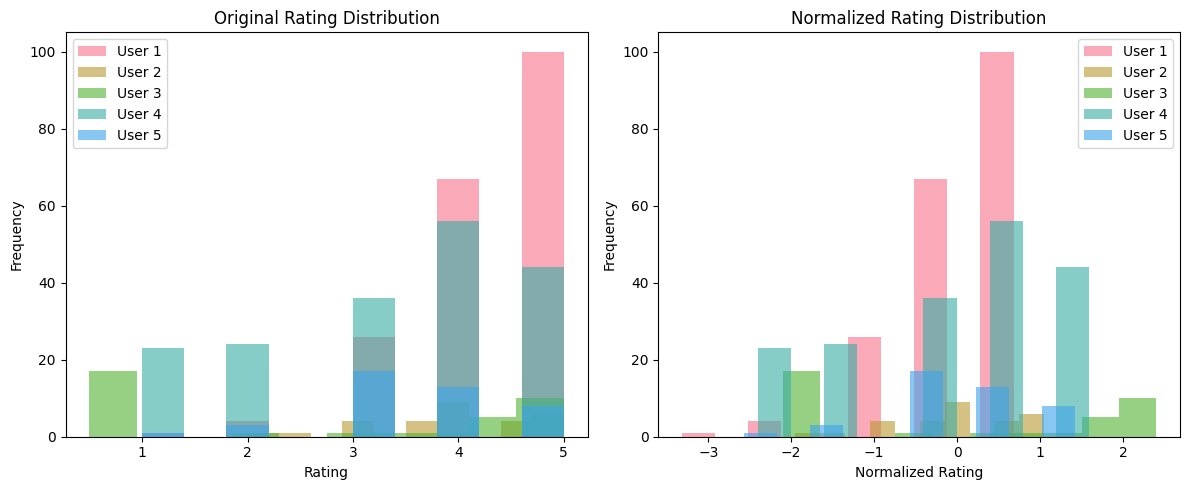

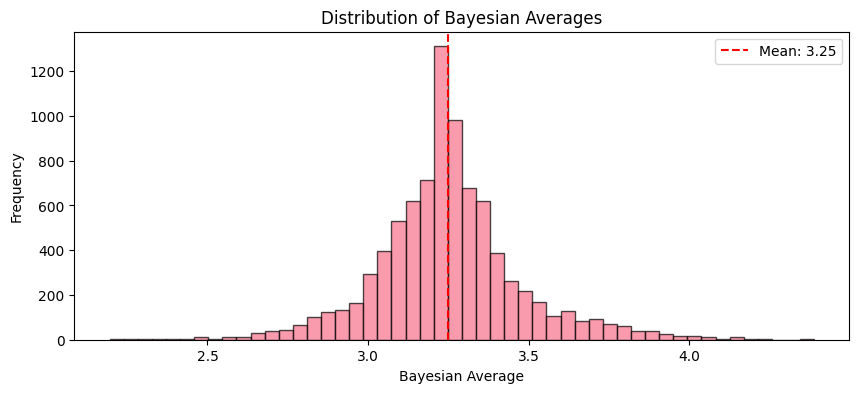

In [20]:
# Analysis of normalization effectiveness
def plot_normalization_effect():
    """
    Visualizes the effect of normalization on ratings.
    """
    plt.figure(figsize=(12, 5))
    
    # Distribution before normalization
    plt.subplot(1, 2, 1)
    sample_users = ratings[ratings['userId'].isin([1, 2, 3, 4, 5])]
    for user_id in [1, 2, 3, 4, 5]:
        user_ratings = sample_users[sample_users['userId'] == user_id]['rating']
        plt.hist(user_ratings, alpha=0.6, label=f'User {user_id}', bins=10)
    plt.title('Original Rating Distribution')
    plt.xlabel('Rating')
    plt.ylabel('Frequency')
    plt.legend()
    
    # Distribution after normalization
    plt.subplot(1, 2, 2)
    sample_users_norm = ratings_normalized[ratings_normalized['userId'].isin([1, 2, 3, 4, 5])]
    for user_id in [1, 2, 3, 4, 5]:
        user_ratings_norm = sample_users_norm[sample_users_norm['userId'] == user_id]['rating_normalized']
        plt.hist(user_ratings_norm, alpha=0.6, label=f'User {user_id}', bins=10)
    plt.title('Normalized Rating Distribution')
    plt.xlabel('Normalized Rating')
    plt.ylabel('Frequency')
    plt.legend()
    
    plt.tight_layout()
    plt.show()

plot_normalization_effect()

# Analysis of Bayesian score distribution
plt.figure(figsize=(10, 4))
plt.hist(bayesian_ratings['bayesian_avg'], bins=50, edgecolor='black', alpha=0.7)
plt.title('Distribution of Bayesian Averages')
plt.xlabel('Bayesian Average')
plt.ylabel('Frequency')
plt.axvline(bayesian_ratings['bayesian_avg'].mean(), color='red', linestyle='--', 
            label=f'Mean: {bayesian_ratings["bayesian_avg"].mean():.2f}')
plt.legend()
plt.show()